In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
import aa_test as aa

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# Задача

Есть данные А/А-теста с '2024-02-23' по '2024-02-29'. Оценить корректность работы системы сплитования

# Решение

In [2]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240320'
}
db='simulator_20240320'

In [3]:
date_start = "toDate('2024-02-23')"
date_end = "toDate('2024-02-29')"
groups = "(2, 3)"

q = f"""
WITH feed_actions AS (
    -- Активность пользователей из интересующих групп за указанный период
    SELECT
      time,
      user_id,
      exp_group,
      action
    FROM {db}.feed_actions
    WHERE 
        time>={date_start} AND time<{date_end}+1
        AND exp_group IN {groups}
    ORDER BY time
),
ctrs AS (
    -- Поюзерные ctr'ы
    SELECT
        user_id,
        exp_group,
        countIf(time, action='like') / countIf(time, action='view') AS ctr
    FROM feed_actions
    GROUP BY user_id, exp_group
)

SELECT *
FROM ctrs
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,ctr
0,115383,3,0.153226
1,10326,3,0.181818
2,123580,3,0.204918
3,131473,2,0.193878
4,23985,2,0.272727


In [4]:
df.groupby('exp_group').user_id.nunique()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

  0%|          | 0/10000 [00:00<?, ?it/s]

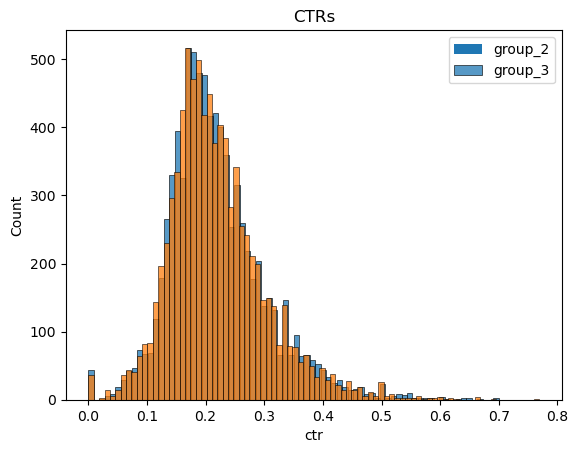

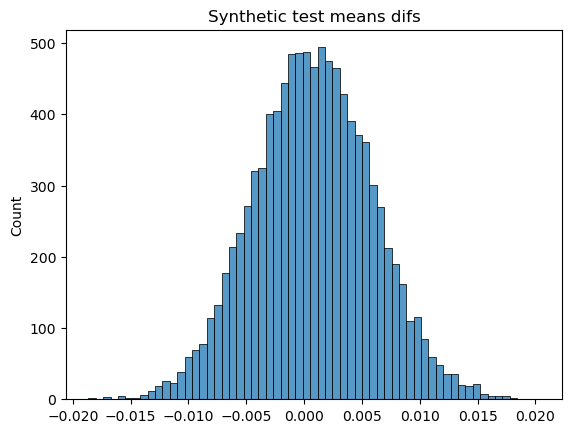

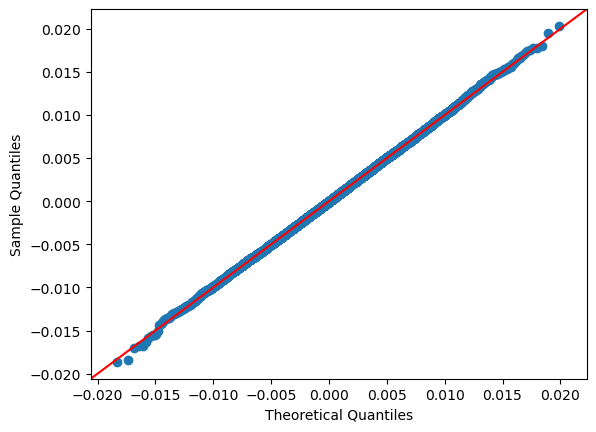

In [5]:
# Проверка возможности применения t-test
N = 10000  # Количество синтетических тестов
n_ss = 500  # Размер подвыборки

a = df.query('exp_group == 2').ctr
b = df.query('exp_group == 3').ctr

means_difs = []
for _ in tqdm(range(N)):
    means_dif = a.sample(n_ss).mean() - b.sample(n_ss).mean()
    means_difs.append(means_dif)
means_difs = np.array(means_difs)

# Графики
plt.figure(1)
sns.histplot(a);
sns.histplot(b);
plt.title('CTRs')
plt.legend(['group_2', 'group_3']);

plt.figure(2)
sns.histplot(means_difs);
plt.title('Synthetic test means difs')

normal_dist = ss.distributions.norm(means_difs.mean(), means_difs.std())
sm.qqplot(means_difs, dist=normal_dist, line="45");

In [6]:
# Однородность дисперсий
ss.levene(a, b)

LeveneResult(statistic=0.3180837497900335, pvalue=0.5727690584368084)

- Ощутимых выбросов нет
- Распределение метрики ~ нормальное
- Дисперсии однородные

=> t-test применим

  0%|          | 0/10000 [00:00<?, ?it/s]

min sample size: 8362
synthetic subsample size: 500


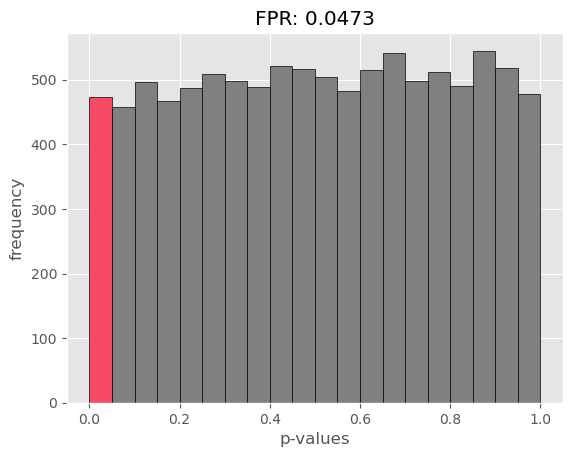

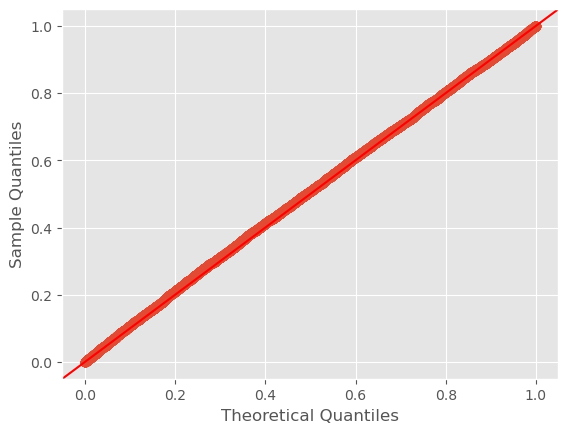

0.0473

In [7]:
aa.synth_test(
    df.query('exp_group == 2').ctr,
    df.query('exp_group == 3').ctr,
    ss_percent=5.979
)

**Выводы**:
- распределение p-value равномерное
- FPR ~ 0.05
- => система сплитования работает корректно